* This is the DeepAR implementation that put together by refering to the Gluonts package documentation (**https://ts.gluon.ai/api/gluonts/gluonts.model.deepar.html**). I have changed its parameters as mentioned in the paper ([MixSeq: Connecting Macroscopic Time Series Forecasting with Microscopic Time Series Data](https://arxiv.org/pdf/2110.14354.pdf)) to generate the first component. The other two components can be generated by adding gaussian Noise N (0, 0.01) to the parameters of the base model. This can't be done using the package. Therefore, this notebook cannot be used for generating Synthetic data for our requirement.

However, this could be used for testing on the clustered wikidataset generated by the MixSeq model


In [1]:
!pip install gluonts
!pip install gluonts.trainer

     |████████████████████████████████| 2.8 MB 12.4 MB/s 
     |████████████████████████████████| 10.9 MB 37.4 MB/s 
ERROR: Could not find a version that satisfies the requirement gluonts.trainer (from versions: none)
ERROR: No matching distribution found for gluonts.trainer


In [2]:
!pip install mxnet

     |████████████████████████████████| 47.3 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
import pandas as pd

prediction_length = 100
url = '/content/wiki.csv'
df = pd.read_csv(url, header=0,index_col =0)
data = common.ListDataset([{
    "start": df.index[0],
    "target": df.value[:"2020-06-30"] }],freq="D")

df.tail(5)

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


,value
date,
2020-06-26,170884345
2020-06-27,180648965
2020-06-28,191937779
2020-06-29,181291901
2020-06-30,175741267


/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future ver

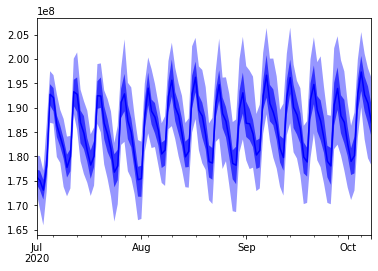

In [4]:
trainer = Trainer(epochs=100)
estimator = deepar.DeepAREstimator(freq="D", prediction_length=100, num_layers=1, num_cells =16, cell_type = 'lstm', trainer=trainer)
predictor = estimator.train(training_data=data)

prediction = next(predictor.predict(data))
#print(prediction.mean)
prediction.plot(output_file='graph.png')

In [5]:
from gluonts.dataset.common import ListDataset
import matplotlib.pyplot as plt
test_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2020-06-30"]}],
    freq = "D"
)


/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


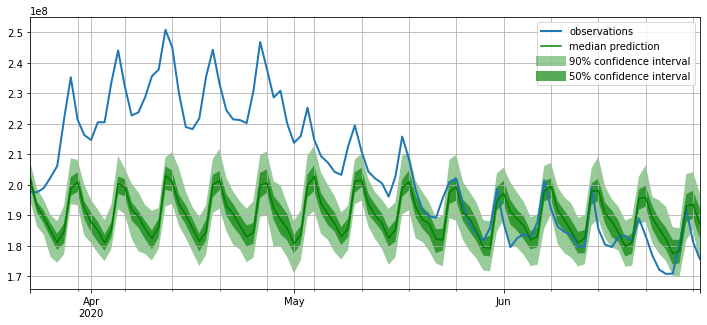

In [6]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=100, num_plots=1)